In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import pickle
import math

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [0]:
base_path = './drive/My Drive/Colab Notebooks/hw4/variational-autoencoder/'
train_path = base_path + 'hw4_tr7.pkl'
test_path = base_path + 'hw4_te7.pkl'

base_path_model = base_path + 'model/'

## Structure of the data

tr7.pkl contains 6,265 MNIST digits from its training set, but not all ten digits. I only selected 7’s. Therefore, it’s with a rank-3 tensor of size 6, 265 × 28 × 28. Similarly, te7.pkl contains 1,028 7’s.

The digit images in this problem are special, because a special effect has been added to them. So, they are different from the original 7’s in the MNIST dataset in a way. The goal of this problem is to find out what effect is applied to the poor 7’s.


In [0]:
with open(train_path, 'rb') as f:
  train = pickle.load(f)
  train = train.reshape([-1, 28, 28, 1])

with open(test_path, 'rb') as f:
  test = pickle.load(f)
  test = test.reshape([-1, 28, 28, 1])

In [6]:
train.shape

(6265, 28, 28, 1)

In [7]:
test.shape

(1028, 28, 28, 1)

## Visualize data

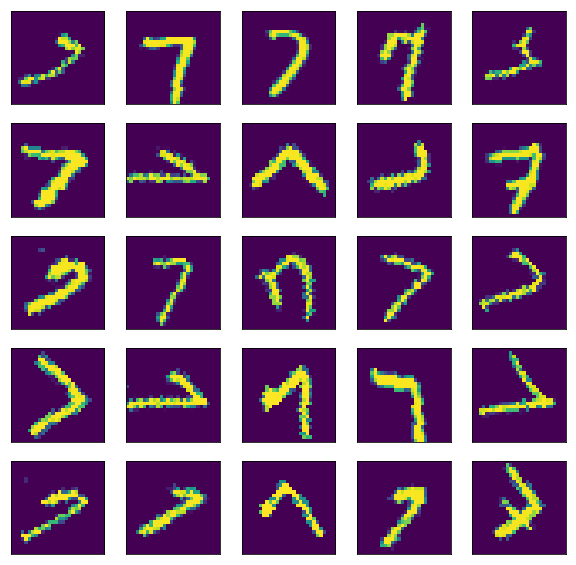

In [8]:
plt.figure(figsize=(10, 10))
for i in range(5):
  for j in range(5):
    ax = plt.subplot(5, 5, 5 * i + j + 1)
    plt.imshow(np.squeeze(train[np.random.randint(0, train.shape[0])]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# Create model

In [0]:
X = tf.placeholder(dtype='float', shape=[None, 28, 28, 1], name='X')
Y = tf.placeholder(dtype='float', shape=[None, 28, 28, 1], name='Y')
Y_flat = tf.reshape(Y, [-1, 28*28])

n_gaussians = 4

In [0]:
def encoder(X):

  conv_1 = tf.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(X)
  # pool_1 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_1)
#   bn_1 = tf.layers.BatchNormalization()(conv_1)

  conv_2 = tf.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(conv_1)
  # pool_2 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
#   bn_2 = tf.layers.BatchNormalization()(conv_2)

  conv_3 = tf.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu, padding='same')(conv_2)
  # pool_3 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_3)
#   bn_3 = tf.layers.BatchNormalization()(conv_3)
  dropout_3 = tf.layers.Dropout(0.2)(conv_3)
  
  print(conv_1)
  print(conv_2)
  print(conv_3)

  flattened = tf.layers.Flatten()(dropout_3)
  dense_1 = tf.layers.Dense(units=200)(flattened)
  dense_2 = tf.layers.Dense(units=50)(dense_1)

  mu = tf.layers.Dense(units=n_gaussians)(dense_2)
  std = tf.layers.Dense(units=n_gaussians)(dense_2)
    
  return mu, std

In [0]:
def decoder(z):
  with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
    dense_1 = tf.layers.Dense(units=50, activation=tf.nn.relu, name='dense_1')(z)
    dense_2 = tf.layers.Dense(units=512, activation=tf.nn.relu, name='dense_2')(dense_1)
    unflatteded = tf.reshape(dense_2, [-1, 4, 4, 32], name='unflattened')

    dconv_1 = tf.layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=(1, 1), activation=tf.nn.relu, name='dconv_1')(unflatteded)
    dconv_2 = tf.layers.Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, name='dconv_2')(dconv_1)

    flattened = tf.layers.Flatten(name='flattened')(dconv_2)
    dense_3 = tf.layers.Dense(units=28 * 28, activation=tf.nn.relu, name='dense_3')(flattened)
    output = tf.reshape(dense_3, [-1, 28, 28, 1], name='output')

    print(dconv_1)
    print(dconv_2)
    print(dense_3)
    print(output)

    return output

In [12]:
mu, std = encoder(X)
z = mu + std * tf.random.normal(tf.shape(mu))

Instructions for updating:
Colocations handled automatically by placer.
Tensor("conv2d/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(?, 4, 4, 32), dtype=float32)


In [13]:
output = decoder(z)

Tensor("decoder/dconv_1/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("decoder/dconv_2/Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("decoder/dense_3/Relu:0", shape=(?, 784), dtype=float32)
Tensor("decoder/output:0", shape=(?, 28, 28, 1), dtype=float32)


## Define loss

Loss in VAE is a function of
1. Reconstruction loss (Mean Squared Error between input image and image generated by the decoder)
2. KL divergence with standard normal distribution

In [0]:
mse = tf.reduce_sum(tf.squared_difference(X, output))
kld = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(std) - tf.log(1e-8 + tf.square(std)) - 1)
loss = mse + kld
optimizer = tf.train.AdamOptimizer(0.0004).minimize(loss)

In [0]:
batch_size = 1000
num_epochs = 250
display_step = 50
log_step = 5
save_step = 50

total_samples_train = train.shape[0]
total_samples_test = test.shape[0]
num_batches_train = int(math.ceil(total_samples_train/batch_size))
num_batches_test = int(math.ceil(total_samples_test/batch_size))

train_loss = []
test_loss = []

In [0]:
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [17]:
# saver.restore(sess, base_path_model + 'model_4950.ckpt')

for epoch in range(1, num_epochs + 1):
  loss_val_tr = 0
  for itr in range(num_batches_train):
    start_idx = itr * batch_size
    end_idx = min((itr + 1) * batch_size, total_samples_train)
    
    batch_x = train[start_idx:end_idx]
    _, lv = sess.run([optimizer, loss], feed_dict={X:batch_x})
    loss_val_tr += lv
    
  loss_val_tr /= total_samples_train
  
  if epoch % log_step == 0:
    train_loss.append(loss_val_tr)
    
    # calculate test loss
    loss_val_te = 0
    for itr in range(num_batches_test):
      start_idx = itr * batch_size
      end_idx = min((itr + 1) * batch_size, total_samples_test)

      batch_x = test[start_idx:end_idx]
      _, lv = sess.run([optimizer, loss], feed_dict={X:batch_x})
      loss_val_te += lv
    loss_val_te /= total_samples_test
    test_loss.append(loss_val_te)
    
  if epoch % display_step == 0:
    print('Epoch: {}, Loss: {}, {}'.format(epoch, loss_val_tr, loss_val_te))
  if epoch % save_step == 0:
    saver.save(sess, base_path_model + 'model_' + str(epoch) + '.ckpt')

Epoch: 50, Loss: 34.66602497755387, 34.15997688501262
Epoch: 100, Loss: 31.884745984636872, 31.72154562389804
Epoch: 150, Loss: 30.75276165328212, 30.85109612728371
Epoch: 200, Loss: 30.41720979025339, 30.89174417577365
Epoch: 250, Loss: 30.029271155476856, 30.639713806864815


### Plot training loss over epochs

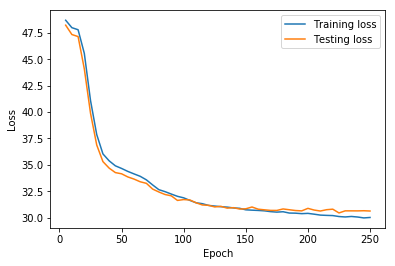

In [18]:
p = plt.plot(log_step + np.arange(0, num_epochs, log_step), train_loss)
p = plt.plot(log_step + np.arange(0, num_epochs, log_step), test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Testing loss'])

# Testing

Reconstruct images

In [0]:
num_test_samples = 5

idx = np.random.choice(np.arange(test.shape[0]), num_test_samples, replace=False)
original = test[idx]
reconstructed = sess.run(output, feed_dict={X: original})

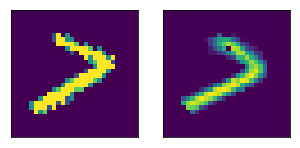

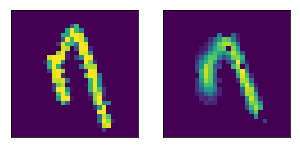

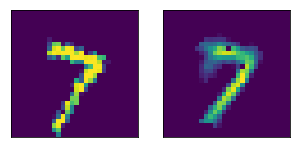

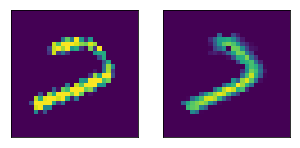

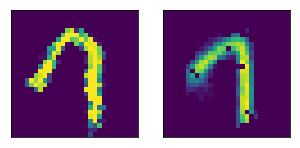

In [20]:
for i in range(num_test_samples):
  plt.figure(figsize=(5, 10))
  
  ax = plt.subplot(1, 2, 1)
  plt.imshow(original[i].reshape([28, 28]))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = plt.subplot(1, 2, 2)
  plt.imshow(reconstructed[i].reshape([28, 28]))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_xticks([])
  ax.set_yticks([])

# Create new images

In [21]:
Z = tf.placeholder(dtype='float', shape=[None, n_gaussians], name='Z')
generate_image = decoder(Z)

Tensor("decoder_1/dconv_1/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("decoder_1/dconv_2/Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("decoder_1/dense_3/Relu:0", shape=(?, 784), dtype=float32)
Tensor("decoder_1/output:0", shape=(?, 28, 28, 1), dtype=float32)


## Take a reference latent vector of a training image 

In [22]:
ref_img = sess.run(z, feed_dict={X: train[:1]})[0]
ref_img

array([-0.86403865, -0.57136416, -0.0611895 , -0.15634428], dtype=float32)

## Change each dimension by keeping others fixed and observe the effect of each dimension

Helper function to plot images

In [0]:
def plot_images(images):
  n = len(images)
  plt.figure(figsize=(20, 20 * n))
  for i in range(n):
      ax = plt.subplot(1, n, i + 1)
      plt.imshow(images[i])
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_xticks([])
      ax.set_yticks([])

Change one dimension at a time keeping others fixed to observe the effect

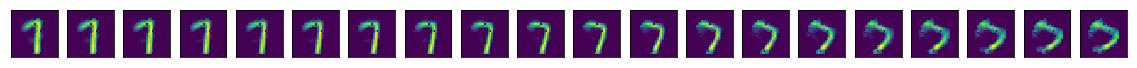

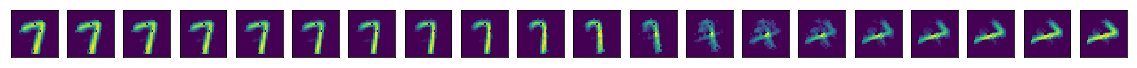

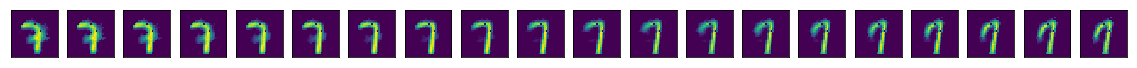

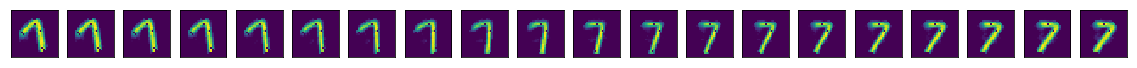

In [24]:
num_tweaked_images = 20
for dim in range(n_gaussians):
  tweaked_vectors = []
  for new_val in np.linspace(-2, 2, num_tweaked_images):
    tweaked_vec = ref_img.copy()
    tweaked_vec[dim] = new_val
    tweaked_vectors.append(tweaked_vec)
  gen_images = sess.run(generate_image, feed_dict={Z: np.array(tweaked_vectors)})
  plot_images(gen_images.reshape([-1, 28, 28]))

# Observations

Looking at the generated images, the network learns parameters which control 

1. Thickness/Brightness
2. Rotation
3. Length and shape of top horizontal line
4. Angle top horizontal line makes with the vertical line
5. Small horizontal line in the middle